In [ ]:
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras import layers
import numpy as np
import random
import matplotlib.pyplot as plt
import os
import glob
import imageio
import PIL
import datetime
import time

from IPython import display

%load_ext tensorboard


The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


# Getting the Candle_Images_Data 

In [ ]:
import urllib
categories = [line.rstrip(b'\n') for line in urllib.request.urlopen('https://raw.githubusercontent.com/googlecreativelab/quickdraw-dataset/master/categories.txt')]
print(categories[:10])
category = 'candle'

[b'aircraft carrier', b'airplane', b'alarm clock', b'ambulance', b'angel', b'animal migration', b'ant', b'anvil', b'apple', b'arm']


In [ ]:
# Creates a folder to download the original drawings into.
# We chose to use the numpy format : 1x784 pixel vectors, with values going from 0 (white) to 255 (black). We reshape them later to 28x28 grids and normalize the pixel intensity to [-1, 1]

if not os.path.isdir('npy_files'):
    os.mkdir('npy_files')
    
url = f'https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/{category}.npy'  
urllib.request.urlretrieve(url, f'npy_files/{category}.npy')

images = np.load(f'npy_files/{category}.npy')
print(f'{len(images)} images to train on')

# You can limit the amount of images you use for training by setting :
train_images = images[:10016]
# You should also define a samller subset of the images for testing..
test_images = images[-1024:] #E: get last 1.000 elements of images

# print(train_images.view())

141545 images to train on


In [ ]:
# 2.1 Prepare dataset
def prep_one(data, batch_size):

  # normalize image
  data = data.map(lambda img: (tf.cast(img, tf.float32)))
  data = data.map(lambda img: (img/128.)-1.)
 
  # the images come as (1,784) pixel arrays
  # then reshape it to shape=(28,28,1) 
  data = data.map(lambda img: (tf.reshape(img, (28,28,1))))

  # shuffle, batch, prefetch
  data = data.shuffle(1000)
  data = data.batch(batch_size)
  data = data.prefetch(20)
  
  return data

In [ ]:
# Define where to save the log
def create_summary_writers(config_name):
  
  current_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
  # create the path for the log file

  train_log_path = f"logs/{config_name}/{current_time}/train"
  val_log_path = f"logs/{config_name}/{current_time}/val"

  # log writer for training metrics
  train_summary_writer = tf.summary.create_file_writer(train_log_path)

  # log writer for validation metrics
  val_summary_writer = tf.summary.create_file_writer(val_log_path)

  # returning the writers for training and validation
  return train_summary_writer, val_summary_writer

train_summary_writer, val_summary_writer = create_summary_writers(config_name="RUN1")

In [ ]:
# Construct a tf.Data.Dataset object using tf.data.Dataset.from_tensor_slices
train_data = tf.data.Dataset.from_tensor_slices(train_images)
test_data = tf.data.Dataset.from_tensor_slices(test_images)

train_ds = prep_one(train_data, 32)
test_ds = prep_one(test_data, 32)

In [ ]:
from tensorflow.python.ops.gen_array_ops import fake_quant_with_min_max_vars_gradient_eager_fallback
class GAN(tf.keras.Model):
    def __init__(self):
      super().__init__()

      self.generator = Generator()
      self.discriminator = Discriminator()

      # optimizer, loss function and metrics
      self.generator_optim = tf.keras.optimizers.Adam(learning_rate=0.00007)
      self.discriminator_optim = tf.keras.optimizers.Adam(learning_rate=0.00007)
      self.loss_f = tf.keras.losses.BinaryCrossentropy()
      self.metrics_list = [tf.keras.metrics.Mean(name="g_loss"),
                             tf.keras.metrics.Mean(name="d_loss")]


    # 3. metrics property
    @property
    def metrics(self):
      return self.metrics_list
      # return a list with all metrics in the model

    # 4. reset all metrics objects
    def reset_metrics(self):
      """
      return a list with all metrics in the model
      """
      for metric in self.metrics:
          metric.reset_states()

    def call(self, inputs):
      # Generate fake data
      fake_data = self.generator(inputs)
      # Pass fake data through the discriminator
      fake_output = self.discriminator(fake_data)
      return fake_output

    
    # 6. test_step method
    def test_step(self, images, real_labels, fake_labels):

      # Generate random noise for the generator
      noise = tf.random.normal((32, 784), 0, 1, tf.float32)

      # Generate fake images
      fake_images = self.generator(noise)
      
      # print("faaaaaaaaaakeeeeeeeeeeee img", fake_images)
      # fake images
      fake_img = self.generator(noise)
      pred = self.discriminator(fake_img)  # prediction of discriminator
      loss_gen = self.loss_f(fake_labels, pred) # Compute the binary cross entropy between the generator’s output on fake images
      loss_dis = self.loss_f(real_labels, pred) # and all labels = 0
      
      # true images
      true_img_pred = self.discriminator(images) # Similarly, compute the BCE between the discriminator’s output on the real images

      # print("fake_img_label = ", "fake_pred", pred.shape, "\n")
      # print("true_img_label = ", "true_pred", true_img_pred.shape, "\n")
      loss_d_true_target = self.loss_f(real_labels, true_img_pred) # and all labels = 1
      loss_discriminator = loss_dis + loss_d_true_target # Add them both

      self.metrics[0].update_state(loss_gen)
      self.metrics[1].update_state(loss_discriminator)
      # print({m.name: m.result() for m in self.metrics})

      # return a dictionary with metric names as keys and metric results as values
      return {m.name: m.result() for m in self.metrics}


    def train_step(self, images, real_labels, fake_labels, plot):
        # Generate random noise for the generator
        noise = tf.random.normal((32, 784), 0, 1, tf.float32)
        # noise = tf.clip_by_value(noise, 0, 1, tf.float32)
        # Generate fake images
        fake_images = self.generator(noise)

        # test_step:
        with tf.GradientTape(persistent=True) as tape:

          # fake images
          fake_img = self.generator(noise)
          
          
          pred = self.discriminator(fake_img)  # prediction of discriminator
          loss_gen = self.loss_f(real_labels, pred) # Compute the binary cross entropy between the generator’s output on fake images
          loss_dis = self.loss_f(fake_labels, pred) # and all labels = 0
          
          # true images
          true_img_pred = self.discriminator(images) # Similarly, compute the BCE between the discriminator’s output on the real images

          loss_d_true_target = self.loss_f(real_labels, true_img_pred) # and all labels = 1
          loss_discriminator = loss_dis + loss_d_true_target # Add them both


        gradients_g = tape.gradient(loss_gen, self.generator.trainable_variables)
        gradients_d = tape.gradient(loss_discriminator, self.discriminator.trainable_variables)

        self.generator_optim.apply_gradients(zip(gradients_g, self.generator.trainable_variables))
        self.discriminator_optim.apply_gradients(zip(gradients_d, self.discriminator.trainable_variables))

        self.metrics[0].update_state(loss_gen)
        self.metrics[1].update_state(loss_discriminator)

        if plot==True:
          for i in range(1, 2):
              image = fake_img[i]
              image = tf.squeeze(image)
              fig, ax = plt.subplots(2, 1, figsize=(5,5))  # Remove the singleton dimensions
        
              plt.imshow(image, cmap=plt.cm.binary)
              plt.title("Noisy Image for Discriminator")
              plt.axis("off")
        

              
          plt.tight_layout()
          plt.show()
          return {m.name: m.result() for m in self.metrics}

        else:
          return {m.name: m.result() for m in self.metrics}


        

In [ ]:
 # training_loop(train_ds, test_ds, 5)

In [ ]:
class Discriminator(tf.keras.Model):
    def __init__(self):
        super().__init__()

        self.dropout_rate = 0.15
        self.batch_norm = True

        if self.dropout_rate: # include dropout_rate
          self.dropout_layer = tf.keras.layers.Dropout(self.dropout_rate)


        self.layer_list = [tf.keras.layers.InputLayer(input_shape=(28, 28, 1)), # downsampling feature maps like a CNN
                           tf.keras.layers.Conv2D(filters=32, kernel_size=3, strides=(2, 2), activation='relu'),
                           tf.keras.layers.Conv2D(filters=64, kernel_size=3, strides=(2, 2), activation='relu'),
                           tf.keras.layers.GlobalMaxPool2D(), #  flatten the feature maps
                           # Last Dense Layer with single neuron for binary classification
                           tf.keras.layers.Dense(units=1, activation='sigmoid')] # sigmoid because of binary classification
                             

        if self.batch_norm: # if batch_norm, add tf.keras.layers.BatchNormalization() layers
        
          self.layer_list = [tf.keras.layers.InputLayer(input_shape=(28, 28, 1)), # downsampling feature maps like a CNN
                             tf.keras.layers.BatchNormalization(),
                             tf.keras.layers.Conv2D(filters=32, kernel_size=3, strides=(2, 2), activation='relu'),
                             tf.keras.layers.BatchNormalization(),
                             tf.keras.layers.Conv2D(filters=64, kernel_size=3, strides=(2, 2), activation='relu'),
                             tf.keras.layers.BatchNormalization(),
                             tf.keras.layers.GlobalMaxPool2D(), #  flatten the feature maps
                             # Last Dense Layer with single neuron for binary classification
                             tf.keras.layers.BatchNormalization(),
                             tf.keras.layers.Dense(units=1, activation='sigmoid')] # sigmoid because of binary classification
                  

    def call(self, x, training=False):
      
      for layer in self.layer_list[:-1]:
                x = layer(x)
                if self.dropout_rate:
                    x = self.dropout_layer(x, training)
      return self.layer_list[-1](x)



In [ ]:
class Generator(tf.keras.Model):
    def __init__(self):
        super().__init__()

        self.dropout_rate = 0
        self.batch_norm = False


        if self.dropout_rate: # include dropout_rate
          self.dropout_layer = tf.keras.layers.Dropout(self.dropout_rate)


        self.layer_list = [tf.keras.layers.Dense(units=7*7), # input is random vector from latent space with shape (784,) which equals 28*28*1 and considering the batch size
                             tf.keras.layers.Reshape(target_shape=(7, 7, 1)), # reshape the resulting vector into feature maps again
                             tf.keras.layers.Conv2DTranspose(filters=64, kernel_size=4, strides=2, padding='same', activation='relu'), # (upsampling or) transposed convolutions to mirror the encoder
                             tf.keras.layers.Conv2D(filters=64, kernel_size=2, strides=1, padding='same', activation='relu'),
                             tf.keras.layers.Conv2DTranspose(filters=32, kernel_size=4, strides=2, padding='same', activation='relu'), # convolution with 1 feature map and tanh activation to produce an output image
                             #tf.keras.layers.Conv2D(filters=64, kernel_size=3, strides=2, padding='same', activation='relu'),
                             tf.keras.layers.Conv2DTranspose(filters=1, kernel_size=4, strides=1, padding='same', activation='tanh')]


        if self.batch_norm: # if batch_norm, add tf.keras.layers.BatchNormalization() layers
        
          self.layer_list = [tf.keras.layers.Dense(units=7*7), # input is random vector from latent space with shape (784,) which equals 28*28*1 and considering the batch size
                             tf.keras.layers.BatchNormalization(),
                             tf.keras.layers.Reshape(target_shape=(7, 7, 1)), # reshape the resulting vector into feature maps again
                             tf.keras.layers.BatchNormalization(),
                             tf.keras.layers.Conv2DTranspose(filters=64, kernel_size=4, strides=2, padding='same', activation='relu'), # (upsampling or) transposed convolutions to mirror the encoder
                             tf.keras.layers.BatchNormalization(),
                             tf.keras.layers.Conv2D(filters=64, kernel_size=2, strides=2, padding='same', activation='relu'),
                             tf.keras.layers.BatchNormalization(),
                             tf.keras.layers.Conv2DTranspose(filters=32, kernel_size=4, strides=2, padding='same', activation='relu'), # convolution with 1 feature map and tanh activation to produce an output image
                             tf.keras.layers.BatchNormalization(),
                             #tf.keras.layers.Conv2D(filters=64, kernel_size=3, strides=2, padding='same', activation='relu'),
                             #tf.keras.layers.BatchNormalization(),
                             tf.keras.layers.Conv2DTranspose(filters=1, kernel_size=4, strides=1, padding='same', activation='tanh')]


    def call(self, x, training=False):
      
      for layer in self.layer_list[:-1]:
                x = layer(x)
                if self.dropout_rate:
                    x = self.dropout_layer(x, training)

                #print("layer", layer, "\n", "shape:",x.shape)
      return self.layer_list[-1](x) # return output


In [ ]:
def training_loop(train_ds, test_ds, epochs, save_path):
  
  # instantiate the model
  gan = GAN()

  # loss, optimizer and metrics
  loss_f = tf.keras.losses.BinaryCrossentropy
  generator_optim = tf.keras.optimizers.Adam(learning_rate=0.001)
  discriminator_optim = tf.keras.optimizers.Adam(learning_rate=0.001)
  metrics_list = [tf.keras.metrics.Mean(name="loss")] 

  # Prepare labels for real and fake images
  real_labels = tf.ones((32, 1))
  fake_labels = tf.zeros((32, 1))


  # train_summary_writer, val_summary_writer = create_log(opt)
  # create new summary_writers\n",
  train_summary_writer, val_summary_writer = create_summary_writers(config_name="RUN1_with_sample_weights")

  ################################## tryyyyyyyyyyyyyyyy ########################################################

  '''for fab in range(2):
    print(f"Epoch {fab}:")

    for data in train_ds:

      metrics = gan.train_dissi(data, real_labels, fake_labels, False)

    print([f"fabbel_{key}: {value.numpy()}" for (key, value) in metrics.items()])


    # reset all metrics
    gan.reset_metrics() 
    '''


  ################################# endeeeeeeeeeeeeeeeeeee ####################################################

  for epoch in range(epochs):
    print(f"Epoch {epoch}:")

    # Validation:
    # (we do the validation first so that we get the accuracy and loss before training the network)
    for data in test_ds:
    
      metrics = gan.test_step(data, real_labels, fake_labels)

      # logging the validation metrics to the log file which is used by tensorboard
      with val_summary_writer.as_default():
          for metric in gan.metrics:
              tf.summary.scalar(f"{metric.name}", metric.result(), step=epoch)
              
    print([f"test_{key}: {value.numpy()}" for (key, value) in metrics.items()])

    # reset all metrics
    gan.reset_metrics() 

    for index, data in enumerate(train_ds):

      if index < 10: 
        metrics = gan.train_step(data, real_labels, fake_labels, True)
      
      else:
        metrics = gan.train_step(data, real_labels, fake_labels, False)
      
    # logging the train metrics to the log file which is used by tensorboard
    with train_summary_writer.as_default(): # context Manager
      for metric in gan.metrics:
        tf.summary.scalar(f"{metric.name}", metric.result(), step=epoch)
            
              
    # print the metrics
    print([f"train_{key}: {value.numpy()}" for (key, value) in metrics.items()])
        
    # reset all metrics
    gan.reset_metrics()
    print("\n")
      

    

In [ ]:
'''if epoch==(epochs-1):

      # Training:
      for data in train_ds.take:
        metrics = gan.train_step(data, labels, True)

    else:
'''

'if epoch==(epochs-1):\n\n      # Training:\n      for data in train_ds.take:\n        metrics = gan.train_step(data, labels, True)\n\n    else:\n'

In [ ]:
save_path = "trained_model_RUN1_sample_weights"

Epoch 0:
['test_g_loss: 0.688686192035675', 'test_d_loss: 1.5372284650802612']


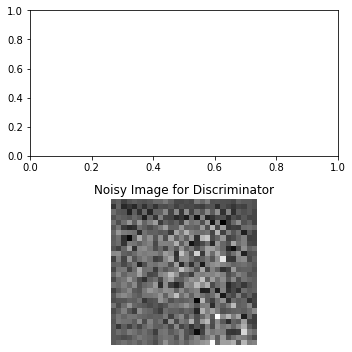

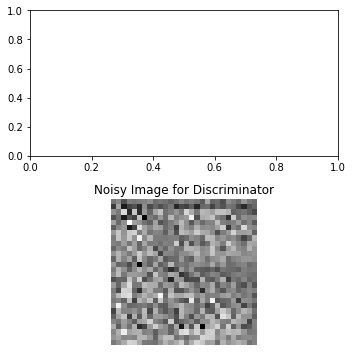

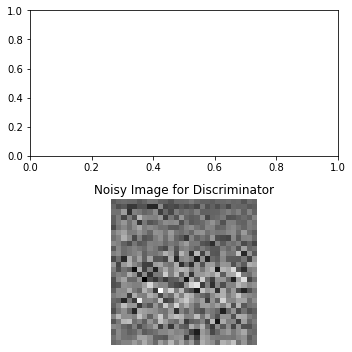

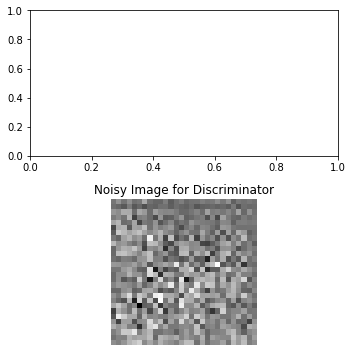

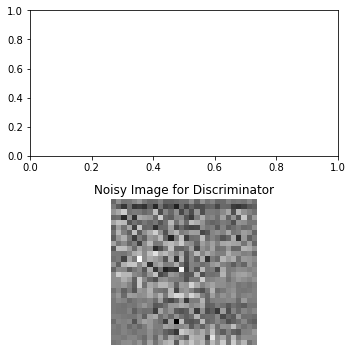

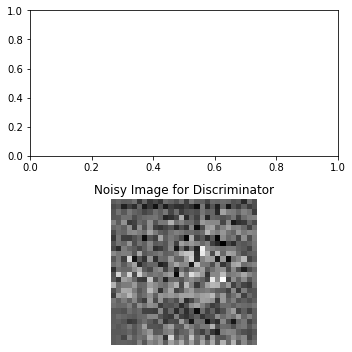

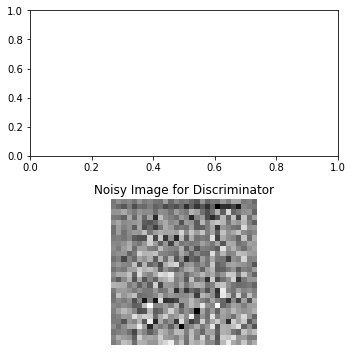

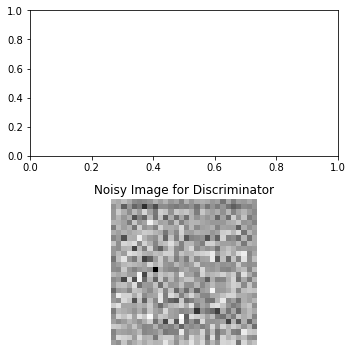

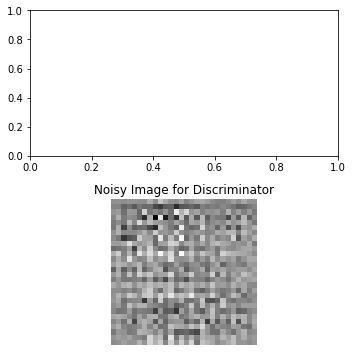

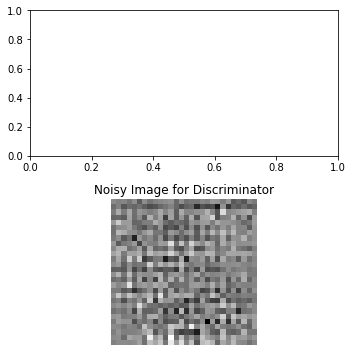

['train_g_loss: 0.7641343474388123', 'train_d_loss: 1.028869390487671']


Epoch 1:
['test_g_loss: 0.3275430202484131', 'test_d_loss: 1.4356776475906372']


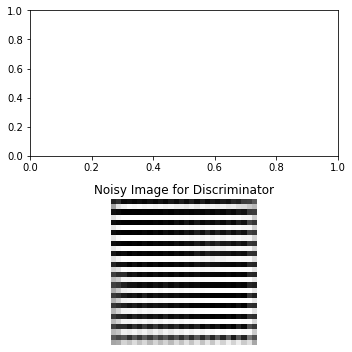

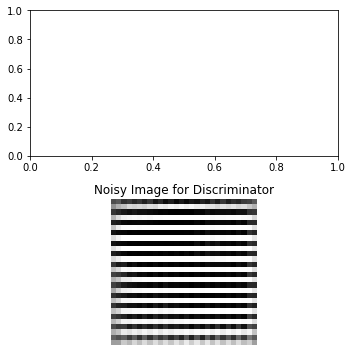

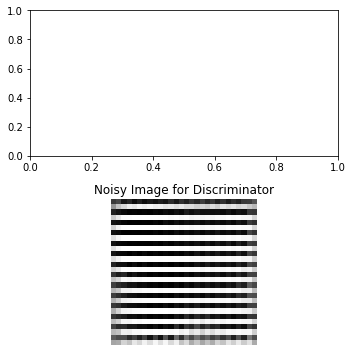

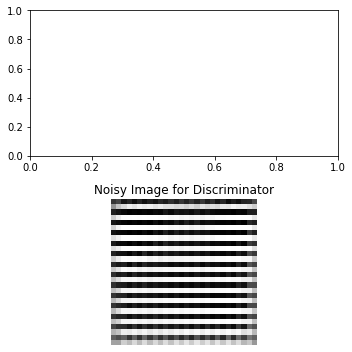

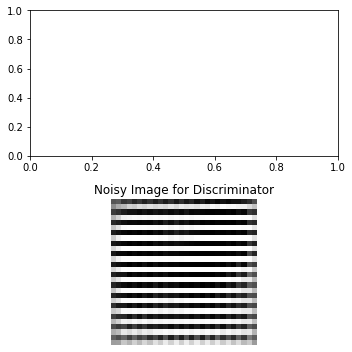

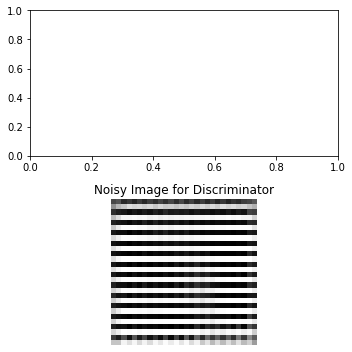

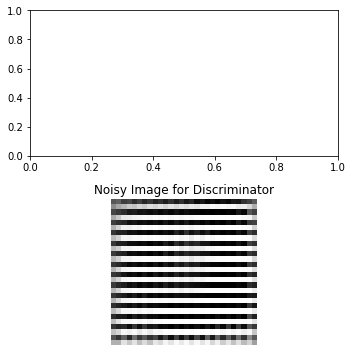

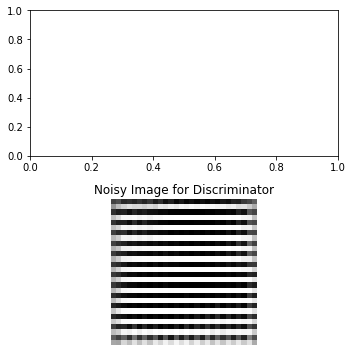

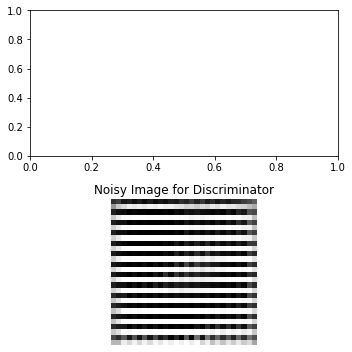

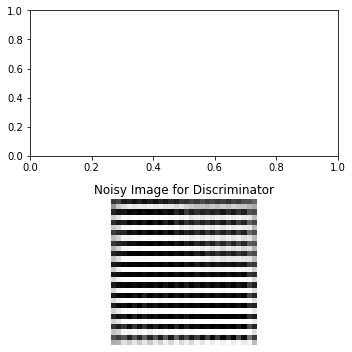

['train_g_loss: 0.9751673936843872', 'train_d_loss: 0.787671685218811']


Epoch 2:
['test_g_loss: 0.6285095810890198', 'test_d_loss: 1.3805439472198486']


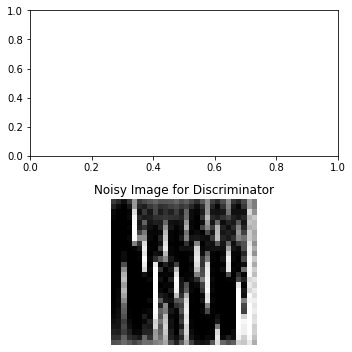

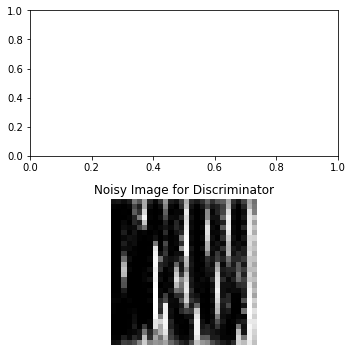

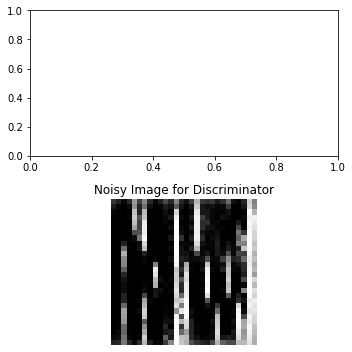

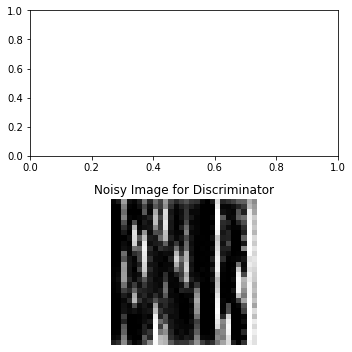

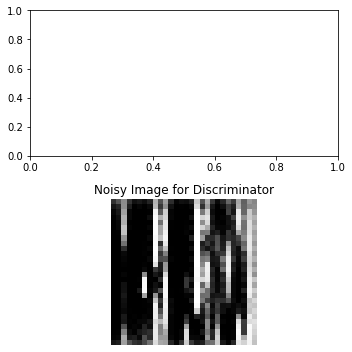

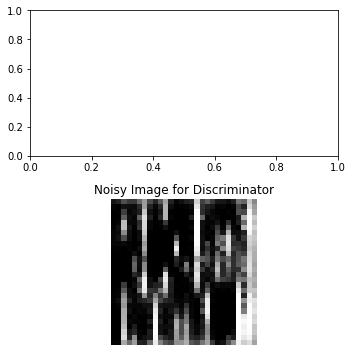

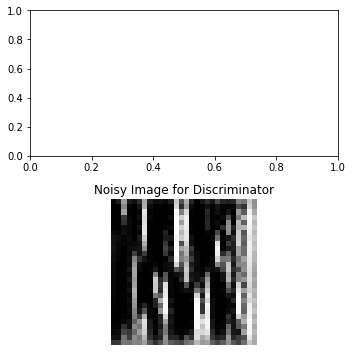

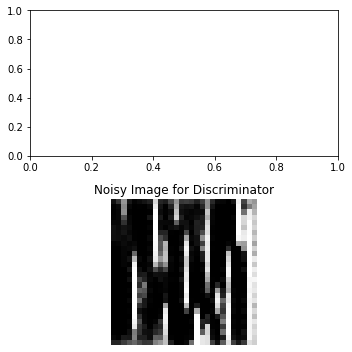

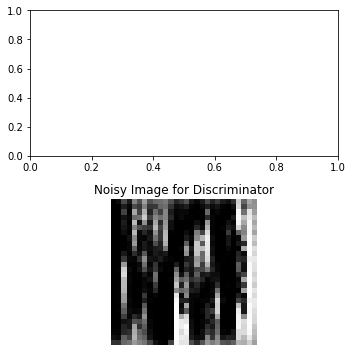

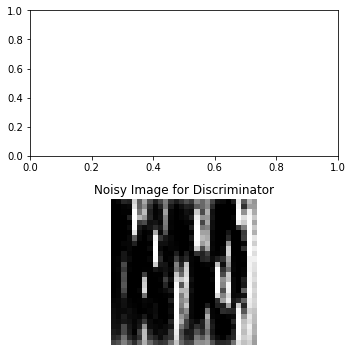

['train_g_loss: 1.0582878589630127', 'train_d_loss: 0.9284695982933044']


Epoch 3:
['test_g_loss: 0.23396557569503784', 'test_d_loss: 1.7599432468414307']


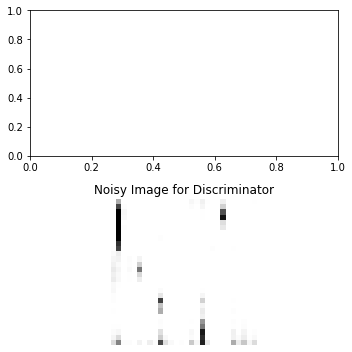

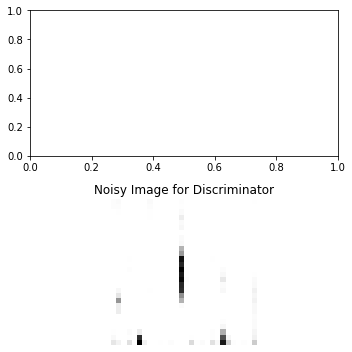

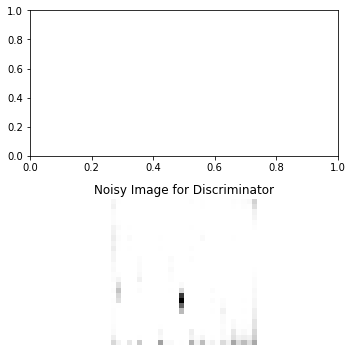

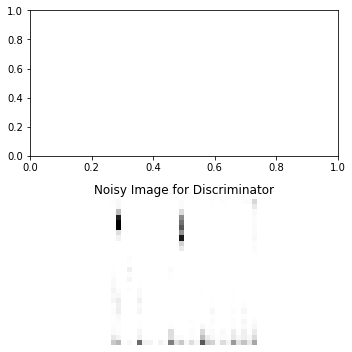

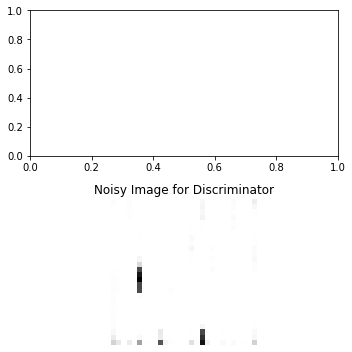

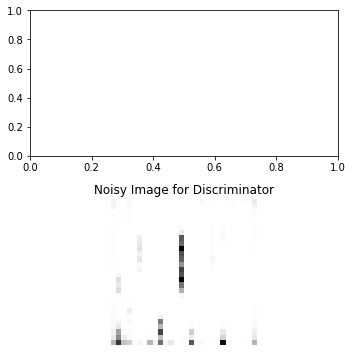

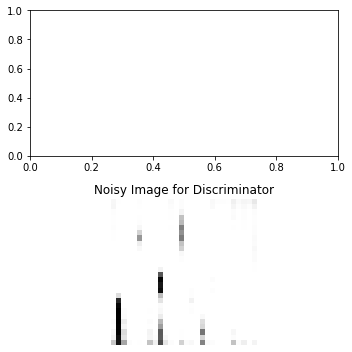

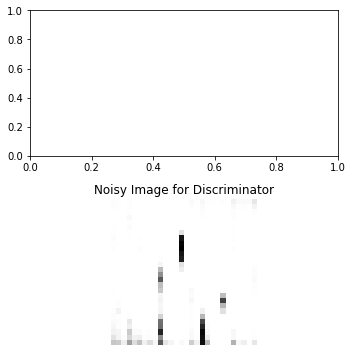

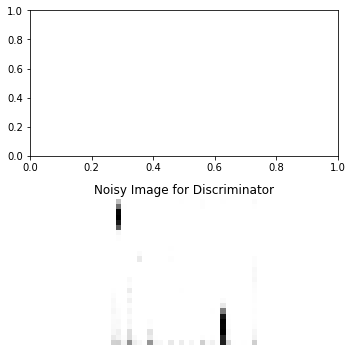

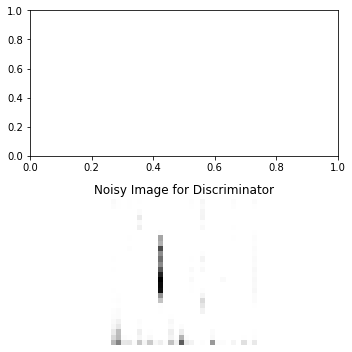

['train_g_loss: 1.4235906600952148', 'train_d_loss: 0.5974650979042053']


Epoch 4:
['test_g_loss: 0.5627546310424805', 'test_d_loss: 1.4359232187271118']


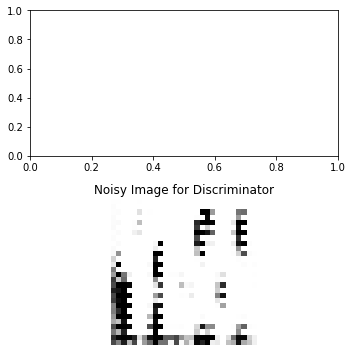

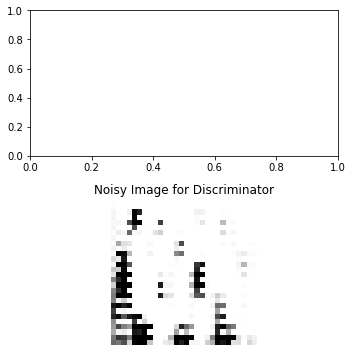

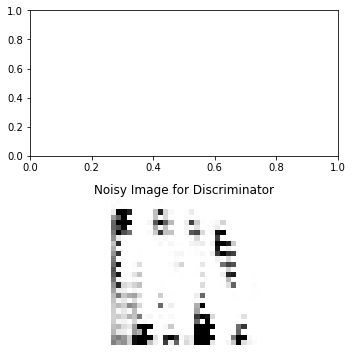

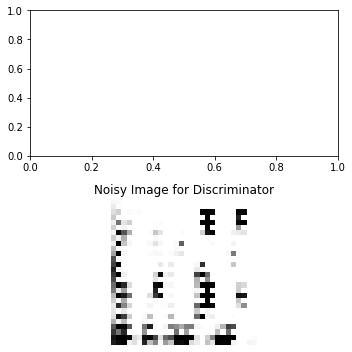

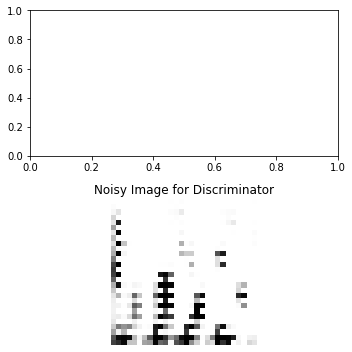

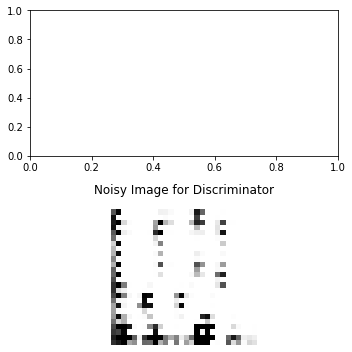

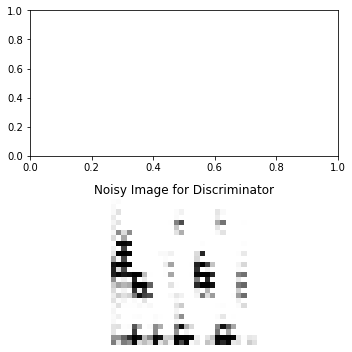

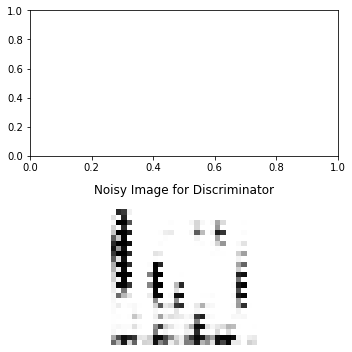

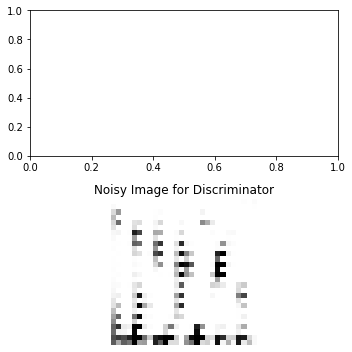

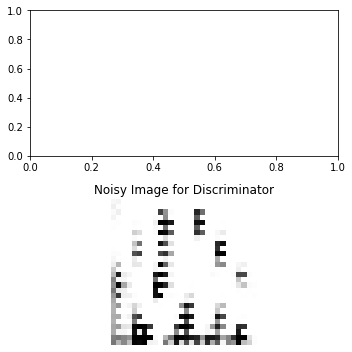

['train_g_loss: 1.3616352081298828', 'train_d_loss: 0.6770706176757812']


Epoch 5:
['test_g_loss: 0.18898168206214905', 'test_d_loss: 1.9938901662826538']


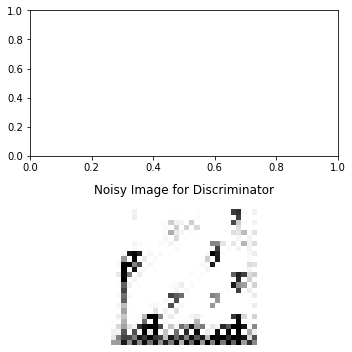

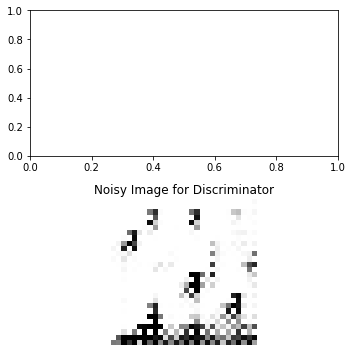

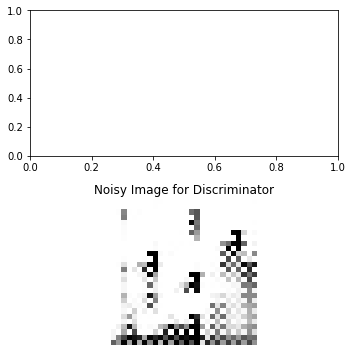

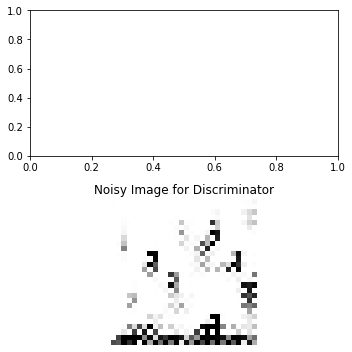

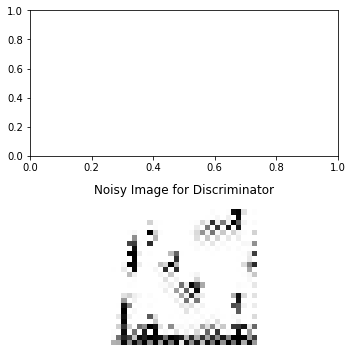

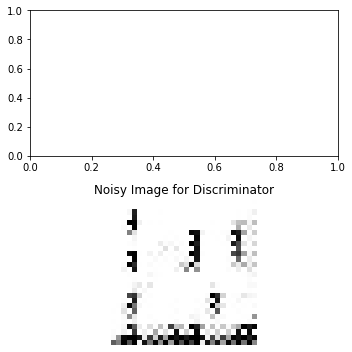

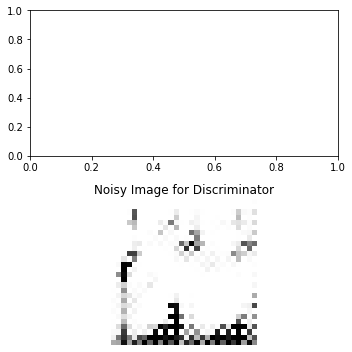

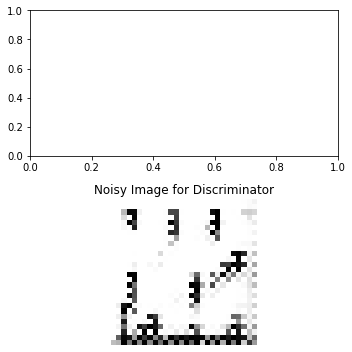

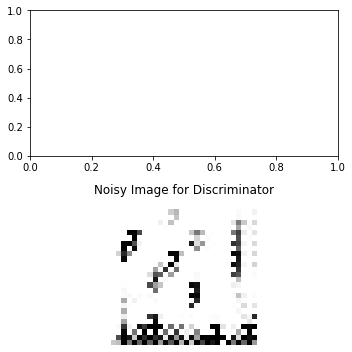

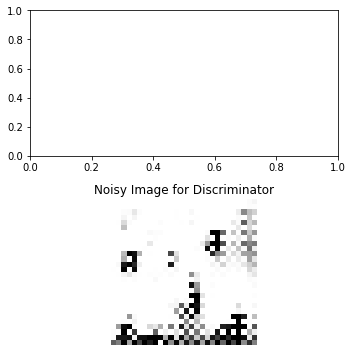

['train_g_loss: 1.3530203104019165', 'train_d_loss: 0.7426273226737976']


Epoch 6:
['test_g_loss: 0.41648271679878235', 'test_d_loss: 1.5827569961547852']


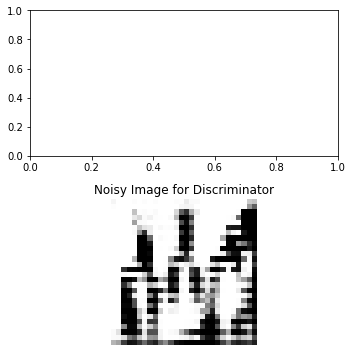

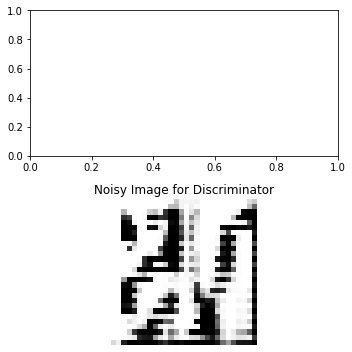

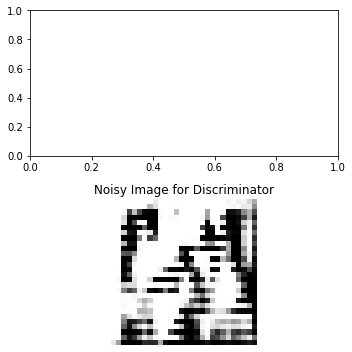

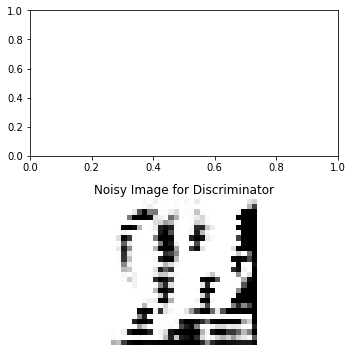

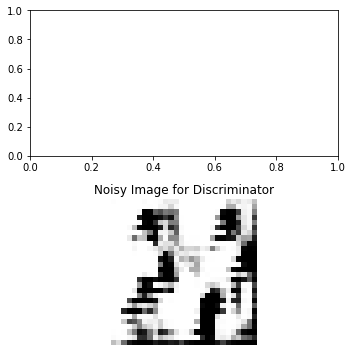

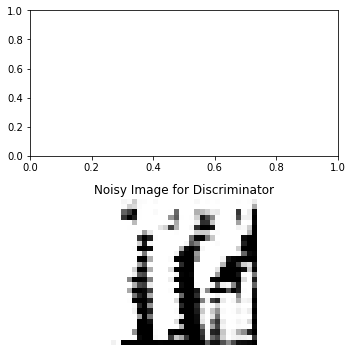

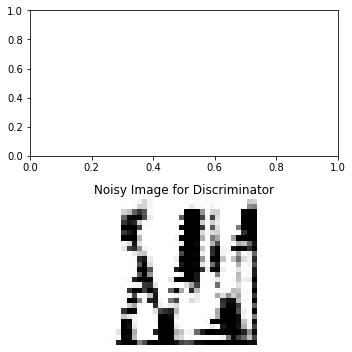

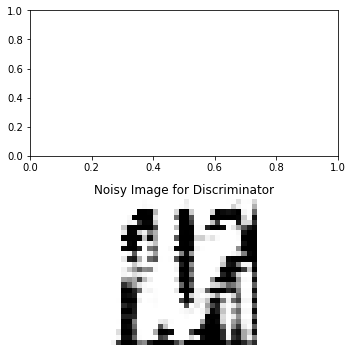

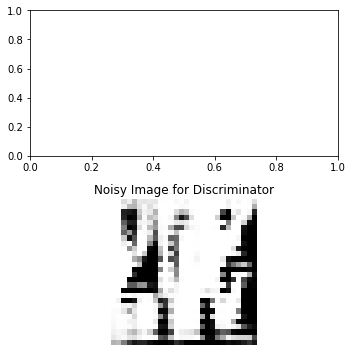

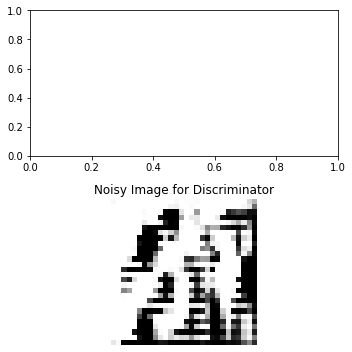

['train_g_loss: 1.2883700132369995', 'train_d_loss: 0.7455775141716003']


Epoch 7:
['test_g_loss: 0.3133503496646881', 'test_d_loss: 1.7114660739898682']


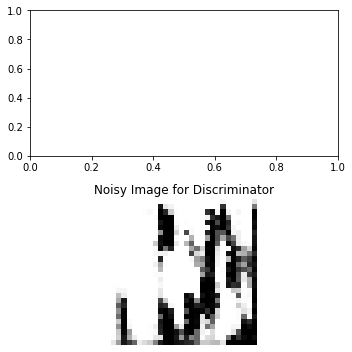

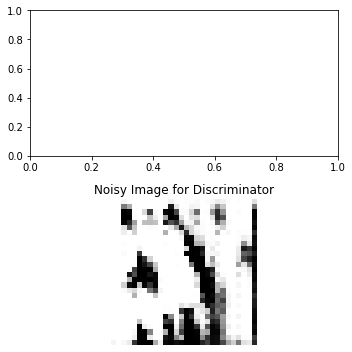

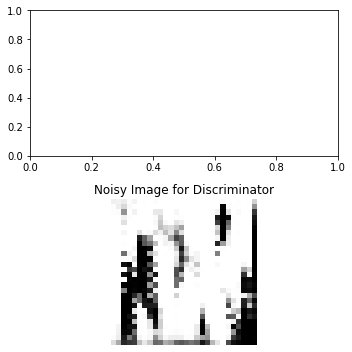

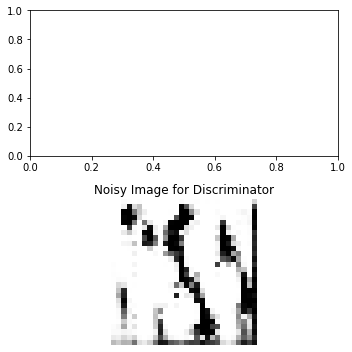

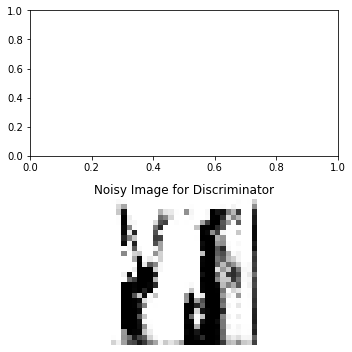

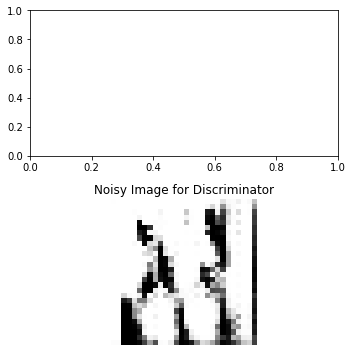

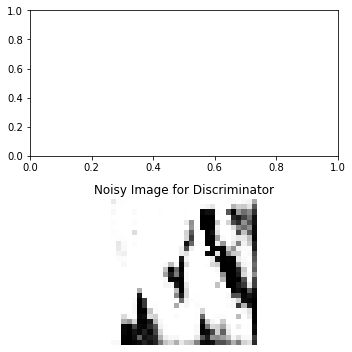

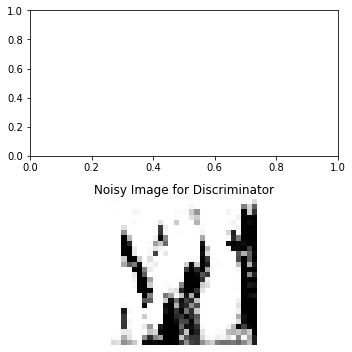

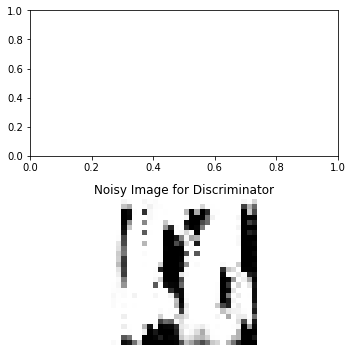

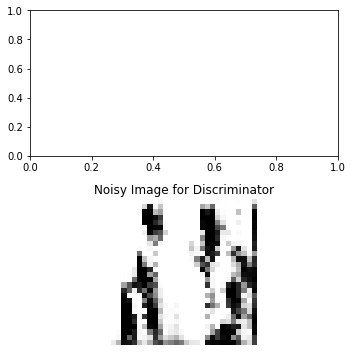

['train_g_loss: 1.4753254652023315', 'train_d_loss: 0.6040953397750854']


Epoch 8:
['test_g_loss: 0.24060946702957153', 'test_d_loss: 1.9136345386505127']


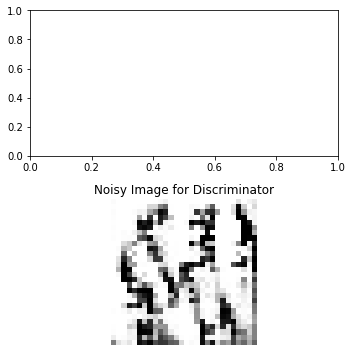

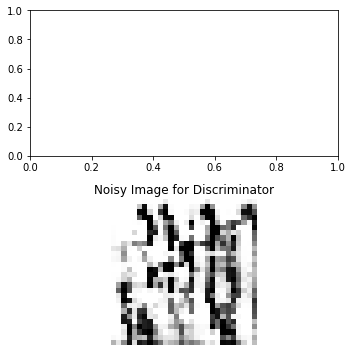

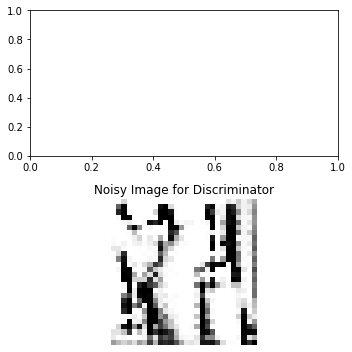

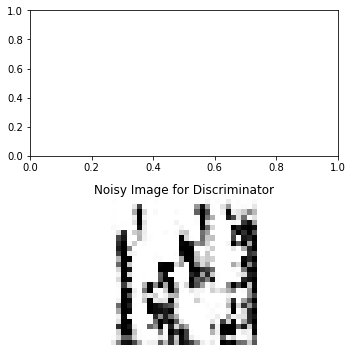

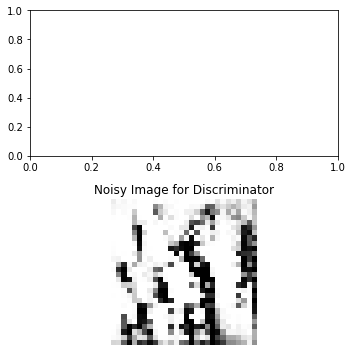

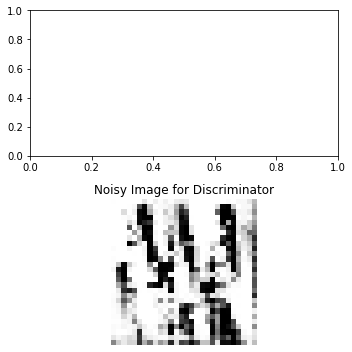

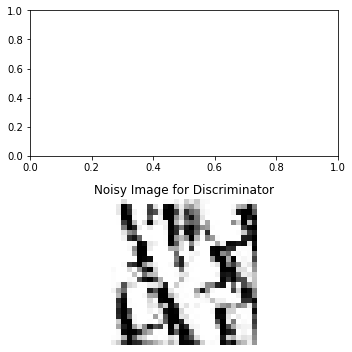

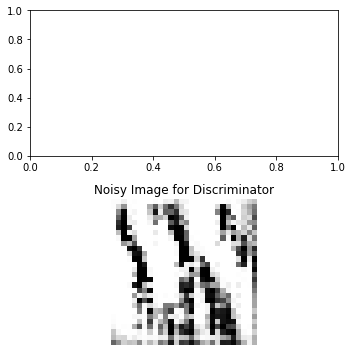

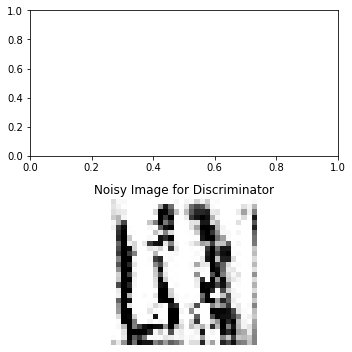

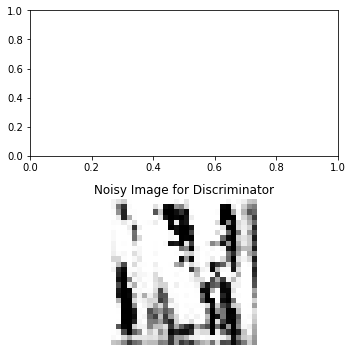

['train_g_loss: 1.513000249862671', 'train_d_loss: 0.6021376848220825']


Epoch 9:
['test_g_loss: 0.2761155664920807', 'test_d_loss: 1.7826706171035767']


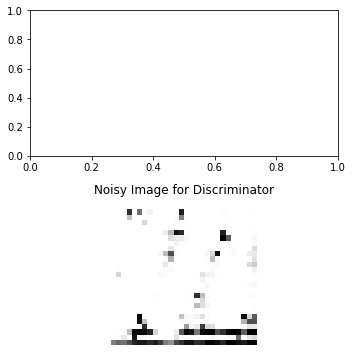

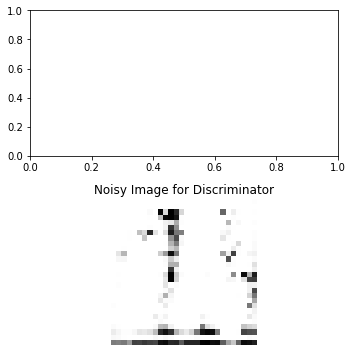

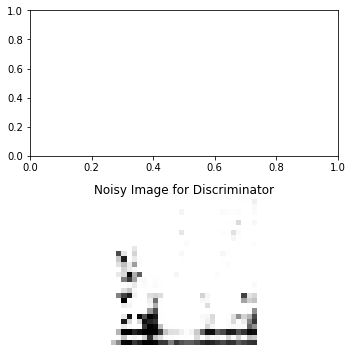

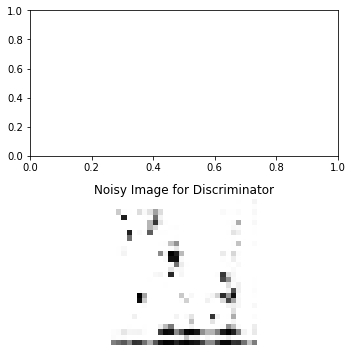

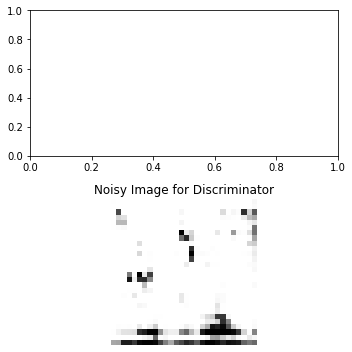

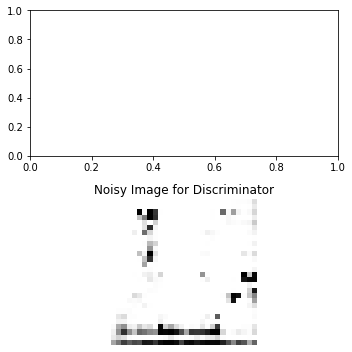

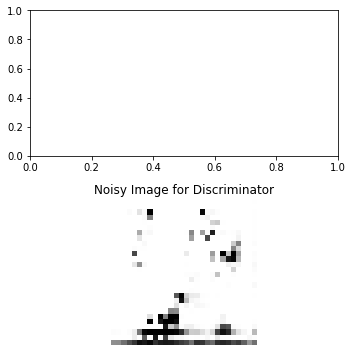

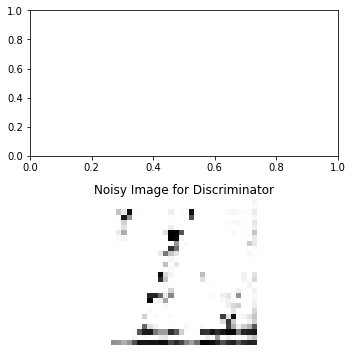

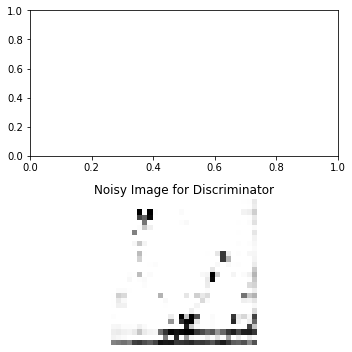

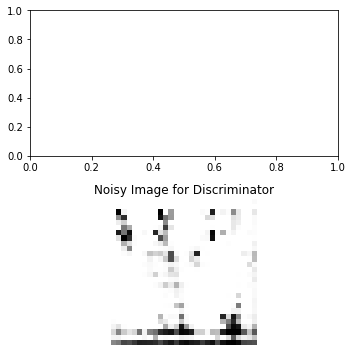

['train_g_loss: 1.6849862337112427', 'train_d_loss: 0.5621951222419739']


Epoch 10:
['test_g_loss: 0.21120721101760864', 'test_d_loss: 2.091214179992676']


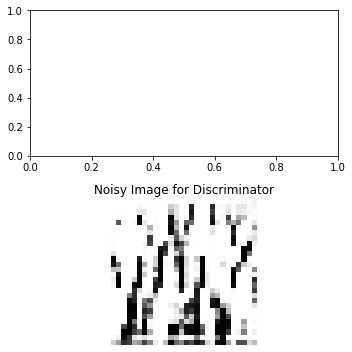

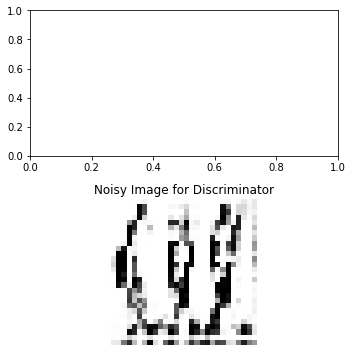

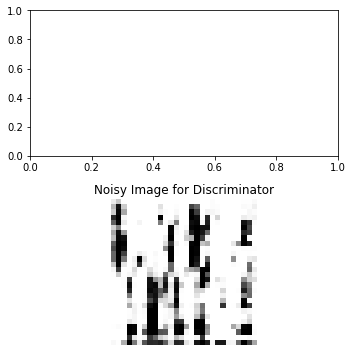

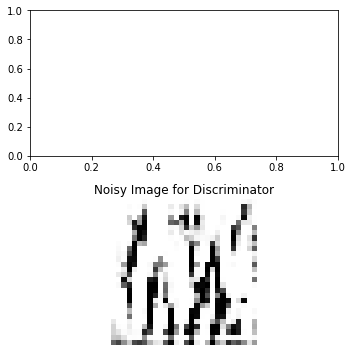

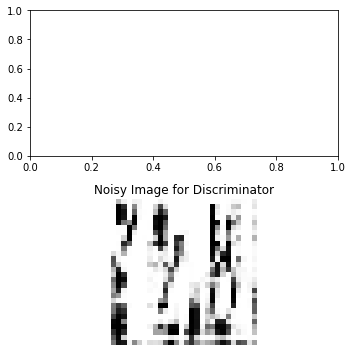

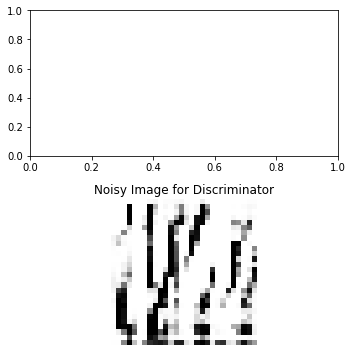

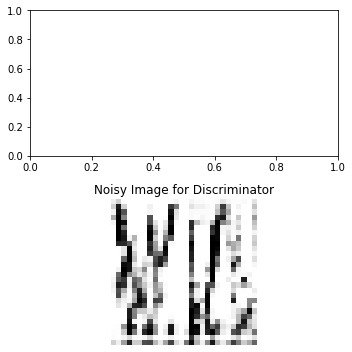

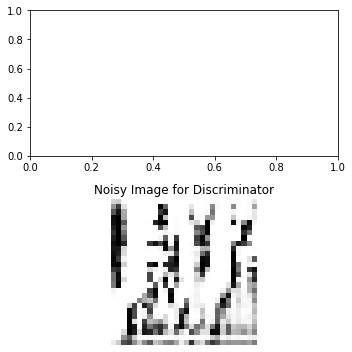

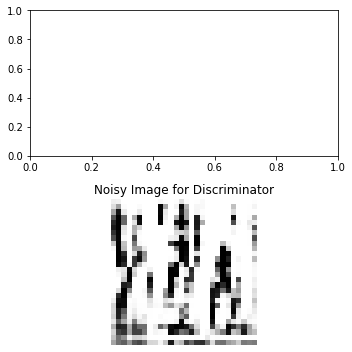

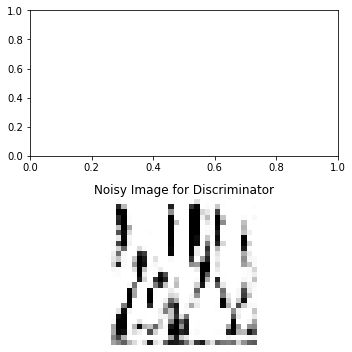

['train_g_loss: 2.4569919109344482', 'train_d_loss: 0.2953490614891052']


Epoch 11:
['test_g_loss: 0.27696698904037476', 'test_d_loss: 1.6521672010421753']


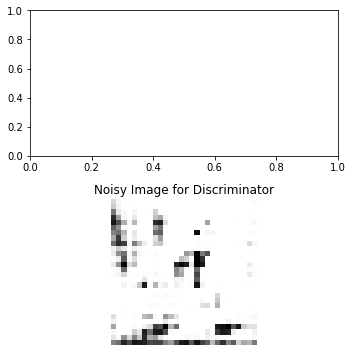

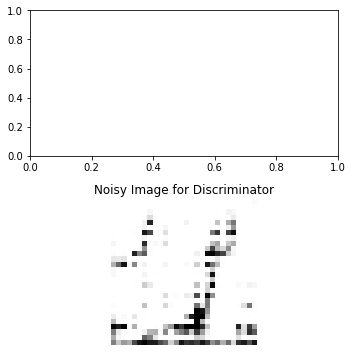

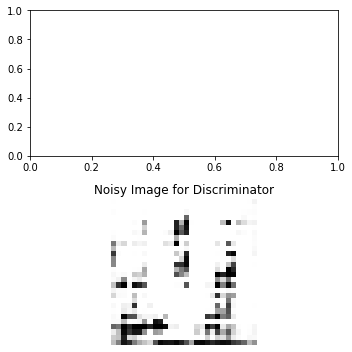

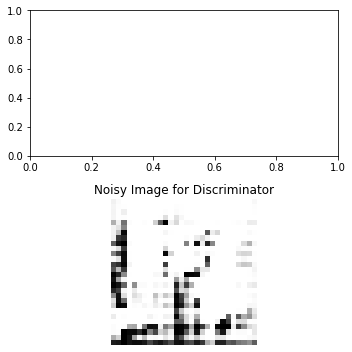

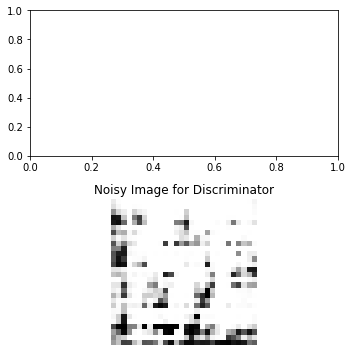

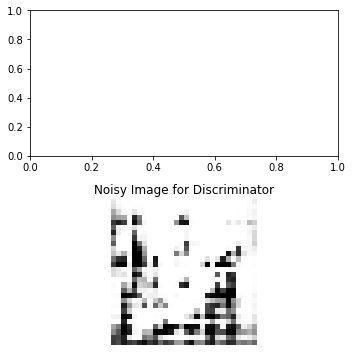

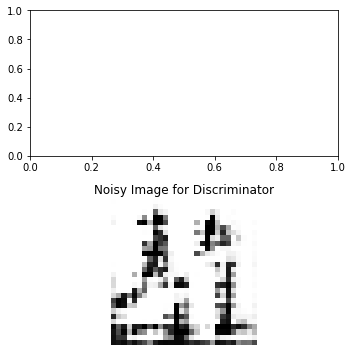

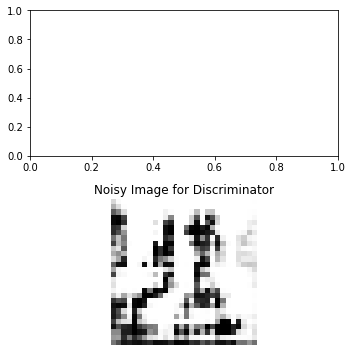

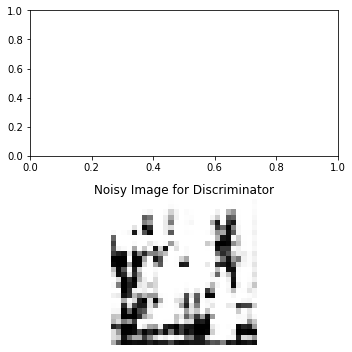

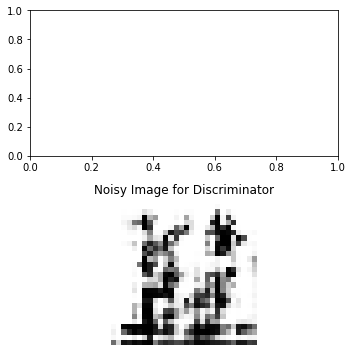

['train_g_loss: 2.008899688720703', 'train_d_loss: 0.4410984516143799']


Epoch 12:
['test_g_loss: 0.15431298315525055', 'test_d_loss: 2.3804140090942383']


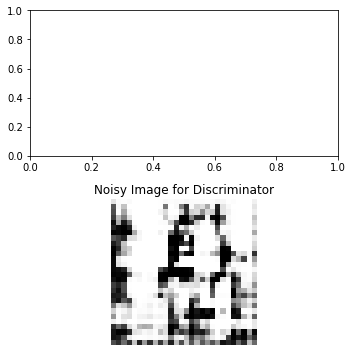

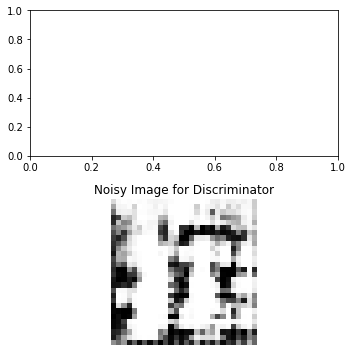

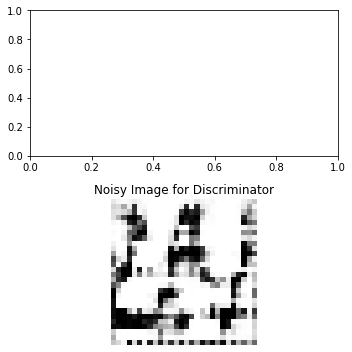

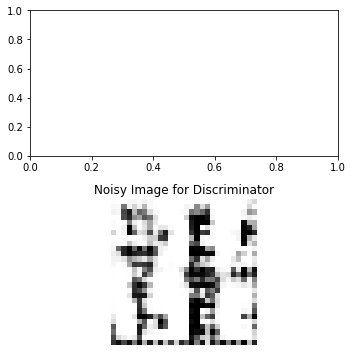

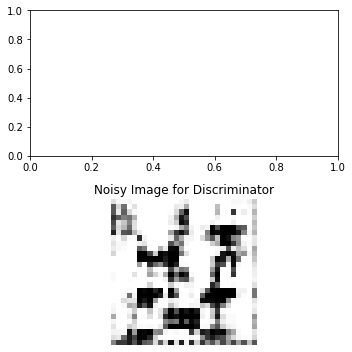

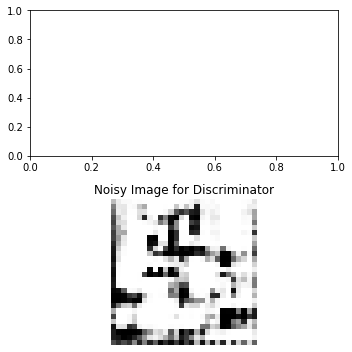

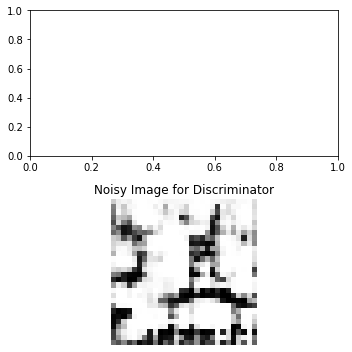

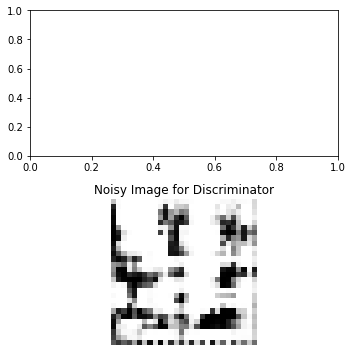

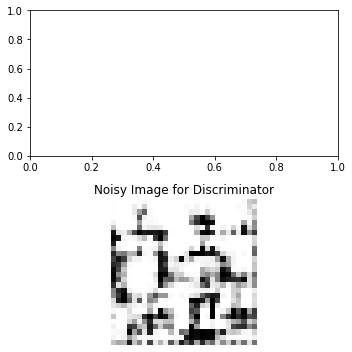

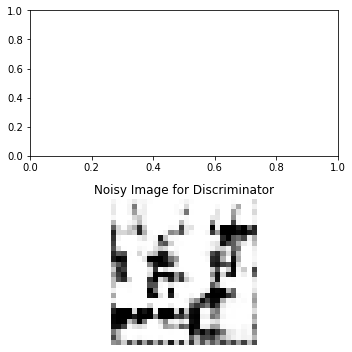

['train_g_loss: 2.1804802417755127', 'train_d_loss: 0.3377738296985626']


Epoch 13:
['test_g_loss: 0.1323016732931137', 'test_d_loss: 2.4931445121765137']


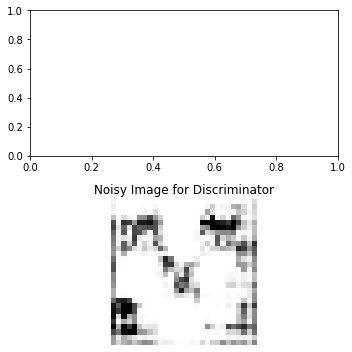

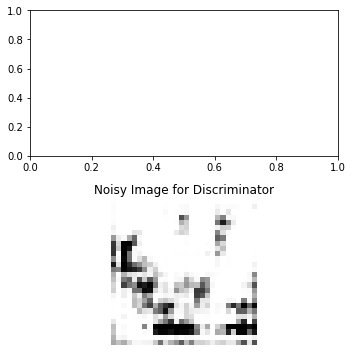

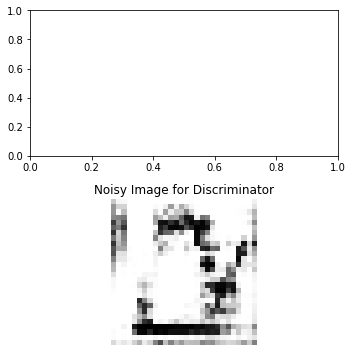

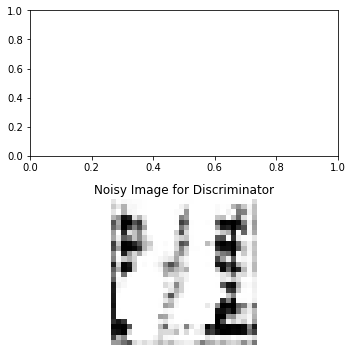

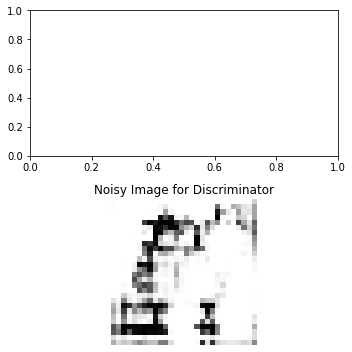

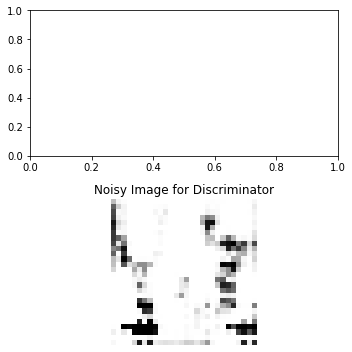

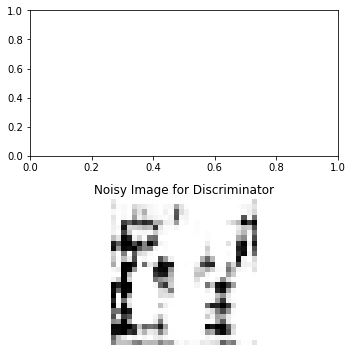

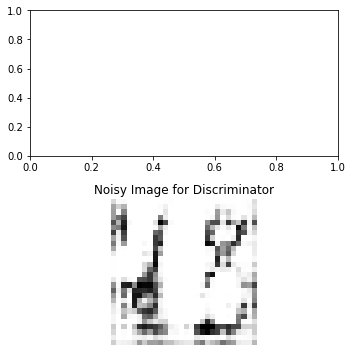

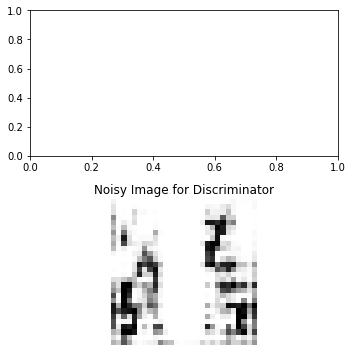

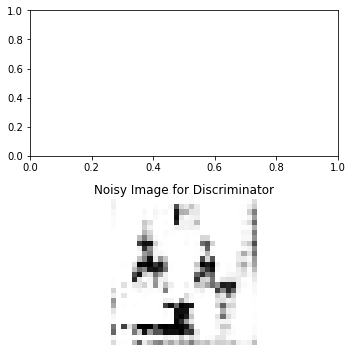

['train_g_loss: 2.304020643234253', 'train_d_loss: 0.34854674339294434']


Epoch 14:
['test_g_loss: 0.0735108032822609', 'test_d_loss: 3.0839879512786865']


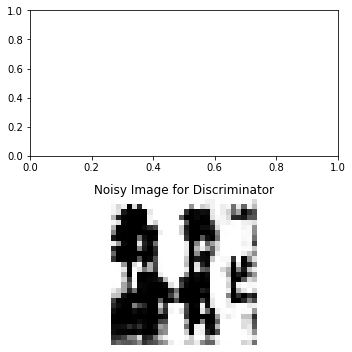

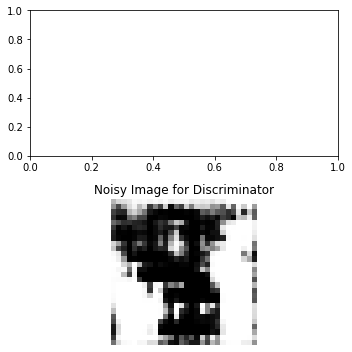

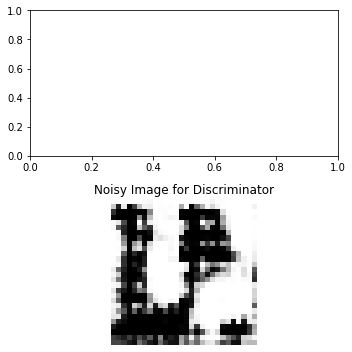

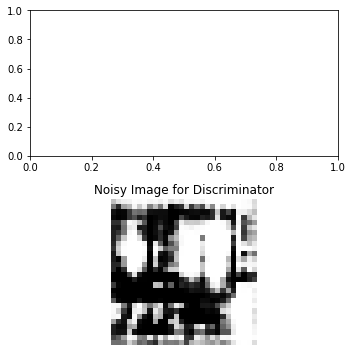

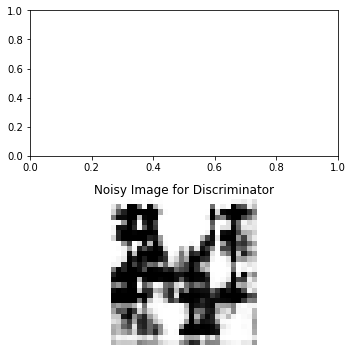

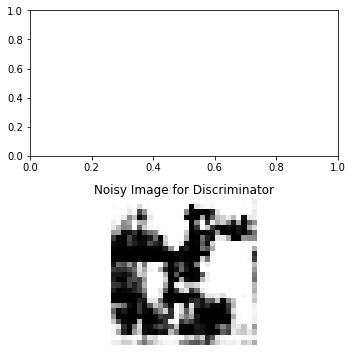

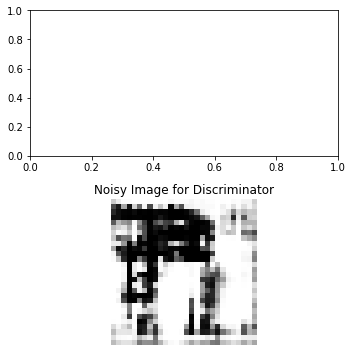

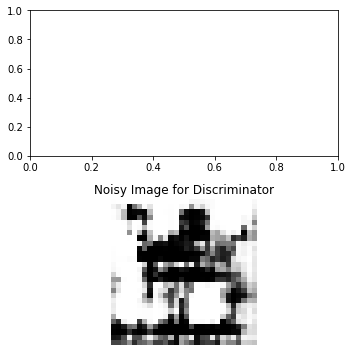

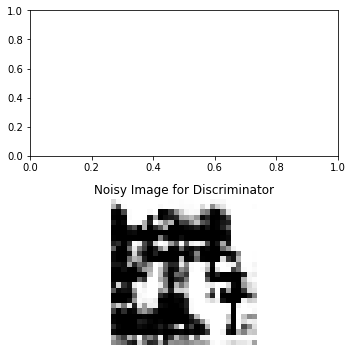

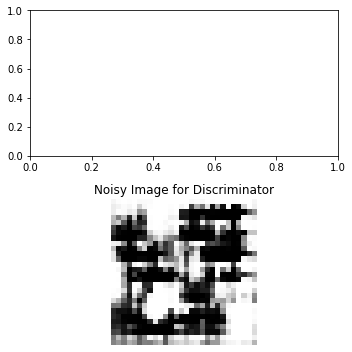

['train_g_loss: 2.544574499130249', 'train_d_loss: 0.31207770109176636']




In [ ]:
#find
training_loop(train_ds, test_ds, 15, f"logs/{str(save_path)}/weights")

In [ ]:
# open the tensorboard logs
# %tensorboard --logdir logs/